In [1]:
# 서버 용량 알아보기
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         122G   42G   80G  35% /
tmpfs            64M     0   64M   0% /dev
tmpfs           3.7G     0  3.7G   0% /sys/fs/cgroup
/dev/sdb        125G   49G   77G  39% /aiffel/aiffel
/dev/sda1       122G   42G   80G  35% /etc/hosts
shm              64M  4.0K   64M   1% /dev/shm
tmpfs           3.5G   12K  3.5G   1% /run/secrets/kubernetes.io/serviceaccount
tmpfs           3.7G     0  3.7G   0% /proc/acpi
tmpfs           3.7G     0  3.7G   0% /proc/scsi
tmpfs           3.7G     0  3.7G   0% /sys/firmware


# 데이터 형태 살펴보기

## submission 예시 살펴보기

- 어떤 형태로 가공해서 데이터를 제출해야 하는지 살펴봅니다.

In [2]:
import pandas as pd

sub_df = pd.read_csv("./data/sample_submission.csv")
print("number of test data : ", len(sub_df))

display(sub_df.head())

number of test data :  112199


,key_id,word
0,9000003627287624,The_Eiffel_Tower airplane donut
1,9000010688666847,The_Eiffel_Tower airplane donut
2,9000023642890129,The_Eiffel_Tower airplane donut
3,9000038588854897,The_Eiffel_Tower airplane donut
4,9000052667981386,The_Eiffel_Tower airplane donut


- 제출해야할 데이터의 row는 총 112,199개의 정답을 제출해야 합니다.
- 제출형태는 `key_id` 와 `word` 입니다.
- `9000003627287624` 라는 key_id의 그림에 대해 모델이 3가지 예측을 한 것을 의미합니다.
    - The_Eiffel_Tower
    - airplane
    - donut
- 제출시에는 모델이 예측한 3개의 단어가 쉼표없이 공백으로 구분이 되어서 입력되어야 하는 것 같습니다.

----

- 실제 학습할 데이터 샘플을 살펴보겠습니다.

## 학습데이터 샘플 살펴보기
- submission 파일에 포함된 에펠탑에 대한 데이터셋을 샘플로 살펴보겠습니다.
- 제공된 데이터셋을 보면 종류도 `raw`와 `simplified`가 있는데 이것도 같이 살펴보겠습니다.
    - 의미나 실제 파일의 용량으로봐서는 `simplified`의 좌표가 더 간결한 데이터라 예상됩니다.

In [3]:
train_file_path = "./data/train_raw/" # 원본 파일 (약 512mb)
train_simple_file_path = "./data/train_simplified/" # 심플버전(약 46mb)

In [4]:
# 파일 불러오기
eiffel_simple = pd.read_csv(train_simple_file_path + "The Eiffel Tower.csv")
eiffel_raw = pd.read_csv(train_file_path + "The Eiffel Tower.csv")

# 각 데이터프레임 출력
display(eiffel_simple.head())
print("\n")  # 줄바꿈 추가
display(eiffel_raw.head())

,countrycode,drawing,key_id,recognized,timestamp,word
0,GB,"[[[0, 22, 37, 64, 255], [218, 220, 227, 228, 2...",5027286841556992,True,2017-03-11 14:47:44.052420,The Eiffel Tower
1,FR,"[[[47, 47, 36, 26, 0, 10, 23, 46, 46, 63, 68, ...",5716269791707136,True,2017-03-12 22:51:18.525950,The Eiffel Tower
2,GB,"[[[184, 115, 67, 57, 36, 18], [251, 103, 12, 1...",5942899998982144,True,2017-03-29 01:12:00.367980,The Eiffel Tower
3,US,"[[[0, 187, 177, 132, 105, 79, 38, 19, 11], [24...",6226163091374080,True,2017-03-29 16:48:54.912900,The Eiffel Tower
4,GB,"[[[0, 21, 43, 83, 97, 158, 169, 172], [162, 16...",4889008825958400,True,2017-03-04 15:50:45.198010,The Eiffel Tower


,countrycode,drawing,key_id,recognized,timestamp,word
0,GB,"[[[16, 33.507999420166016, 44.75699996948242, ...",5027286841556992,True,2017-03-11 14:47:44.052420,The Eiffel Tower
1,FR,"[[[142.64599609375, 141.76100158691406, 141.67...",5716269791707136,True,2017-03-12 22:51:18.525950,The Eiffel Tower
2,GB,"[[[559, 560, 556, 549, 542, 532, 520, 509, 494...",5942899998982144,True,2017-03-29 01:12:00.367980,The Eiffel Tower
3,US,"[[[151, 160, 173, 195, 224, 254, 287, 320, 355...",6226163091374080,True,2017-03-29 16:48:54.912900,The Eiffel Tower
4,GB,"[[[216, 229, 244, 266, 293, 322, 352, 383, 417...",4889008825958400,True,2017-03-04 15:50:45.198010,The Eiffel Tower


- 실제 학습 데이터를 보면 5개의 컬럼이 있습니다.
- `countrycode` : 그림을 그린 사람의 국가
- `drawing` : 그림의 좌표값
- `key_id` : 인덱스 (고유 id)
- `recognized` : 기존 모델의 인식 여부
- `timestamp` : 그린 시간
- `word` : 정답 label

---

- 일단 submission 데이터와의 차이점 1가지가 보입니다.
- `word` 를 보면 submission 파일과는 다르게 단어간에 `_` 이 없이 텍스트가 입력되어 있습니다.

In [5]:
eiffel_simple.iloc[0][-1]

'The Eiffel Tower'

In [6]:
eiffel_raw.iloc[0][-1]

'The Eiffel Tower'

- 텍스트만 출력해서 보니 띄어쓰기만 되어 있고 `_`는 붙어있지 않습니다.


> 즉, `The Eiffel Tower` 같이 n개 이상의 단어가 합쳐져 하나의 의미를 이루는 단어는 submission 파일을 만들때는 `_` 를 붙여서 제출해야 하는 것 같습니다.

- 다음으로 raw데이터와 simple 버전의 용량 차이가 큰 이유를 확인해보겠습니다.
- head()로 볼때는 `drawing` 컬럼을 빼고는 모두 동일해 보입니다.
- 처음 예상처럼 `drawing` 처럼의 데이터차이인지 확인해보겠습니다.

In [7]:
# 두 데이터프레임을 비교하여 같은지 다른지 비교한 결과를 새로운 데이터프레임으로 생성
comparison_result = (eiffel_simple == eiffel_raw)

# 결과를 표로 출력
comparison_result

,countrycode,drawing,key_id,recognized,timestamp,word
0,True,False,True,True,True,True
1,True,False,True,True,True,True
2,True,False,True,True,True,True
3,True,False,True,True,True,True
4,True,False,True,True,True,True
...,...,...,...,...,...,...
134796,True,False,True,True,True,True
134797,True,False,True,True,True,True
134798,True,False,True,True,True,True
134799,True,False,True,True,True,True


In [8]:
# 두 데이터프레임을 비교하여 같은지 다른지 비교한 결과를 새로운 데이터프레임으로 생성
comparison_result = (eiffel_simple == eiffel_raw)

# 컬럼별로 모든 행이 True인지 검사하여 결과를 컬럼별로 저장
column_comparison = comparison_result.all()

# 컬럼별로 하나라도 False가 있으면 False, 모두 True일 경우 True로 표시
column_comparison = column_comparison.apply(lambda x: "True" if x else "False")

# 결과를 출력
column_comparison

countrycode    False
drawing        False
key_id          True
recognized      True
timestamp       True
word            True
dtype: object

In [9]:
# 'countrycode' 컬럼에서 다른 부분만 출력
different_rows = eiffel_simple[~comparison_result['countrycode']]

# 다른 부분 출력
different_rows

,countrycode,drawing,key_id,recognized,timestamp,word
29746,NaN,"[[[0, 29, 65, 72, 76, 84, 97, 94, 98, 111, 127...",5382100247117824,True,2017-03-21 17:55:42.508840,The Eiffel Tower
38745,NaN,"[[[0, 15, 28, 58], [230, 246, 245, 185]], [[0,...",6543364109369344,True,2017-03-21 18:05:46.880740,The Eiffel Tower
62699,NaN,"[[[69, 62, 49, 25, 0], [8, 87, 149, 212, 255]]...",4995356964159488,True,2017-03-21 12:12:39.495760,The Eiffel Tower
112022,NaN,"[[[81, 75, 73, 63, 0], [0, 11, 61, 104, 234]],...",4937910182739968,True,2017-03-11 11:02:46.008150,The Eiffel Tower


- `countrycode` 에 일부 NaN값이 있어서 그렇지 실제로 차이가 있는것은 `drawing`컬럼인 것 같습니다.
- 실제로 `drawing` 컬럼에 대해 비교해보면서 차이를 살펴보겠습니다.

In [10]:
# 첫 번째 데이터프레임에서 'drawing' 컬럼의 배열 요소 수 카운트
eiffel_simple['drawing_count'] = eiffel_simple['drawing'].apply(len)

# 두 번째 데이터프레임에서 'drawing' 컬럼의 배열 요소 수 카운트
eiffel_raw['drawing_count'] = eiffel_raw['drawing'].apply(len)

# 결과 출력
print("simple ver 데이터프레임 'drawing' 컬럼 배열 요소 수:")
display(eiffel_simple['drawing_count'].head())

print("\n raw ver 데이터프레임 'drawing' 컬럼 배열 요소 수:")
display(eiffel_raw['drawing_count'].head())

simple ver 데이터프레임 'drawing' 컬럼 배열 요소 수:


0    370
1    282
2    311
3    303
4    339
Name: drawing_count, dtype: int64


 raw ver 데이터프레임 'drawing' 컬럼 배열 요소 수:


0    10550
1     7696
2     2646
3     3060
4     1785
Name: drawing_count, dtype: int64

- 예상대로 raw데이터의 좌표값의 수가 훨씬 많은 것으로 보아 더 촘촘한 좌표값을 가진 데이터로 보여집니다.
- 시각화를 해서 실제로 비교를 해보겠습니다.

In [11]:
import json

# 첫 번째 데이터프레임에서 'drawing' 컬럼의 값을 가져와 파싱하여 리스트 생성
simple_images = [json.loads(draw) for draw in eiffel_simple['drawing'].head().values]

# 두 번째 데이터프레임에서 'drawing' 컬럼의 값을 가져와 파싱하여 리스트 생성
raw_images = [json.loads(draw) for draw in eiffel_raw['drawing'].head().values]

In [12]:
# 각 데이터의 첫 번째 항목을 출력하여 데이터 구조 확인
print("첫 번째 simple 이미지 데이터:")
print(simple_images[0])

첫 번째 simple 이미지 데이터:
[[[0, 22, 37, 64, 255], [218, 220, 227, 228, 211]], [[76, 95, 135, 141, 150, 159, 166, 180, 186, 201], [220, 138, 31, 0, 63, 79, 117, 150, 191, 224]], [[94, 104, 111, 119, 127, 141, 143, 142, 180, 191], [212, 167, 149, 80, 59, 41, 30, 134, 202, 232]], [[109, 127, 137, 147, 150, 162, 172, 185], [122, 120, 104, 97, 99, 124, 128, 128]], [[75, 130, 158], [162, 159, 150]]]


In [13]:
print("\n첫 번째 raw 이미지 데이터:")
print(raw_images[0])


첫 번째 raw 이미지 데이터:
[[[16, 33.507999420166016, 44.75699996948242, 52.5620002746582, 58.189998626708984, 64.90499877929688, 73.16600036621094, 82.36599731445312, 90.95600128173828, 99.41999816894531, 109, 120.08799743652344, 133.61000061035156, 146.77200317382812, 159.43699645996094, 170.01199340820312, 178.48899841308594, 186.35000610351562, 192.79299926757812, 199.4720001220703, 204.9949951171875, 210.7969970703125, 217.86000061035156, 224.9029998779297, 231.375, 238.53799438476562, 245.947998046875, 252.15699768066406, 259.3489990234375, 266.2959899902344, 273, 280.8179931640625, 288.7170104980469, 296.7380065917969, 304.24200439453125, 312.3080139160156, 321.2250061035156, 330.1130065917969, 338.84600830078125, 347.125, 350.1159973144531], [350, 351.0889892578125, 353.135009765625, 355.37799072265625, 359.0950012207031, 361.67999267578125, 362.7179870605469, 363.2080078125, 363.3330078125, 363.3330078125, 363, 362.0660095214844, 360.76300048828125, 359.72601318359375, 358.35900878906

In [20]:
raw_images[0][0]

[[16,
  33.507999420166016,
  44.75699996948242,
  52.5620002746582,
  58.189998626708984,
  64.90499877929688,
  73.16600036621094,
  82.36599731445312,
  90.95600128173828,
  99.41999816894531,
  109,
  120.08799743652344,
  133.61000061035156,
  146.77200317382812,
  159.43699645996094,
  170.01199340820312,
  178.48899841308594,
  186.35000610351562,
  192.79299926757812,
  199.4720001220703,
  204.9949951171875,
  210.7969970703125,
  217.86000061035156,
  224.9029998779297,
  231.375,
  238.53799438476562,
  245.947998046875,
  252.15699768066406,
  259.3489990234375,
  266.2959899902344,
  273,
  280.8179931640625,
  288.7170104980469,
  296.7380065917969,
  304.24200439453125,
  312.3080139160156,
  321.2250061035156,
  330.1130065917969,
  338.84600830078125,
  347.125,
  350.1159973144531],
 [350,
  351.0889892578125,
  353.135009765625,
  355.37799072265625,
  359.0950012207031,
  361.67999267578125,
  362.7179870605469,
  363.2080078125,
  363.3330078125,
  363.3330078125,


In [22]:
# 데이터 차원 확인
dimension_simple = len(simple_images[0])
dimension_raw = len(raw_images[0])

print(f"\n첫 번째 simple 이미지 데이터 차원: {dimension_simple}")
print(f"첫 번째 raw 이미지 데이터 차원: {dimension_raw}")


첫 번째 simple 이미지 데이터 차원: 5
첫 번째 raw 이미지 데이터 차원: 5


In [25]:
# 데이터 차원내 좌표 정보 확인
dimension_simple_xy = len(simple_images[0][0])
dimension_raw_xy = len(raw_images[0][0])

print(f"\n첫 번째 simple 이미지 데이터 좌표 차원: {dimension_simple_xy}")
print(f"첫 번째 raw 이미지 데이터 좌표 차원: {dimension_raw_xy}")


첫 번째 simple 이미지 데이터 좌표 차원: 2
첫 번째 raw 이미지 데이터 좌표 차원: 3


- x,y형태의 2차원 형태를 기대했는데, raw 데이터는 에는 x,y좌표외에 추가적인 정보가 더 있는 것 같습니다.

In [30]:
# 첫 번째 이미지의 첫 번째 획에 대한 x좌표, y좌표, 시간 스탬프 확인
def print_stroke_details(image_data):
    for i, stroke in enumerate(image_data):
        print(f"\n획 {i+1}:")
        print(f"\nx좌표:", stroke[0])  # x 좌표 정보 출력
        print(f"\ny좌표:", stroke[1])  # y 좌표 정보 출력
        if len(stroke) > 2:
            print(f"\n 3번째 정보:", stroke[2])  # 시간 스탬프 정보 출력

print("===== 첫 번째 Simple 이미지의 첫 번째 획 상세 정보 =====")
print_stroke_details(simple_images[0])

===== 첫 번째 Simple 이미지의 첫 번째 획 상세 정보 =====

획 1:

x좌표: [0, 22, 37, 64, 255]

y좌표: [218, 220, 227, 228, 211]

획 2:

x좌표: [76, 95, 135, 141, 150, 159, 166, 180, 186, 201]

y좌표: [220, 138, 31, 0, 63, 79, 117, 150, 191, 224]

획 3:

x좌표: [94, 104, 111, 119, 127, 141, 143, 142, 180, 191]

y좌표: [212, 167, 149, 80, 59, 41, 30, 134, 202, 232]

획 4:

x좌표: [109, 127, 137, 147, 150, 162, 172, 185]

y좌표: [122, 120, 104, 97, 99, 124, 128, 128]

획 5:

x좌표: [75, 130, 158]

y좌표: [162, 159, 150]


In [31]:
print("===== 첫 번째 Raw 이미지의 첫 번째 획 상세 정보 =====")
print_stroke_details(raw_images[0])

===== 첫 번째 Raw 이미지의 첫 번째 획 상세 정보 =====

획 1:

x좌표: [16, 33.507999420166016, 44.75699996948242, 52.5620002746582, 58.189998626708984, 64.90499877929688, 73.16600036621094, 82.36599731445312, 90.95600128173828, 99.41999816894531, 109, 120.08799743652344, 133.61000061035156, 146.77200317382812, 159.43699645996094, 170.01199340820312, 178.48899841308594, 186.35000610351562, 192.79299926757812, 199.4720001220703, 204.9949951171875, 210.7969970703125, 217.86000061035156, 224.9029998779297, 231.375, 238.53799438476562, 245.947998046875, 252.15699768066406, 259.3489990234375, 266.2959899902344, 273, 280.8179931640625, 288.7170104980469, 296.7380065917969, 304.24200439453125, 312.3080139160156, 321.2250061035156, 330.1130065917969, 338.84600830078125, 347.125, 350.1159973144531]

y좌표: [350, 351.0889892578125, 353.135009765625, 355.37799072265625, 359.0950012207031, 361.67999267578125, 362.7179870605469, 363.2080078125, 363.3330078125, 363.3330078125, 363, 362.0660095214844, 360.76300048828125, 

- 각각의 차원은 좌표로 구성된 한 획을 의미하는 것으로 보여집니다.
- raw 데이터의 나머지 1개 차원이 뭔지 궁금했는데, 데이터셋의 github를 보니 아래와 같이 기술되어 있습니다.

- `Where x and y are the pixel coordinates, and t is the time in milliseconds since the first point.`
    - 즉, x는 y픽셀 좌표이며 t첫 번째 지점 이후의 시간(밀리초)로 획이 그려진 시간을 표현하는 값인것 같습니다.
    
- 이를 고려해서 두 데이터의 drawing  커럼의 값을 산점도로 그려보겠습니다.

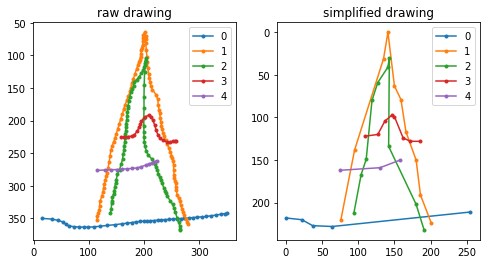

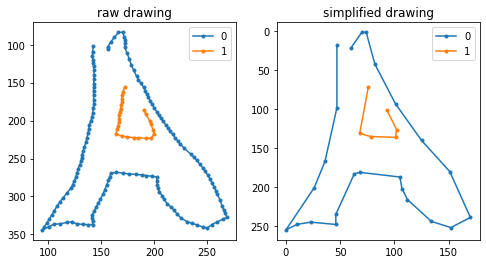

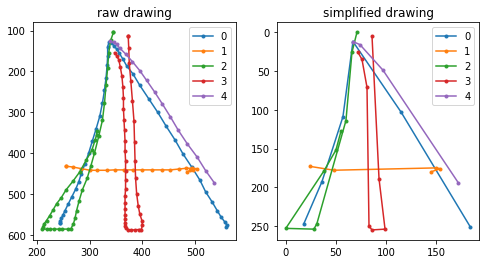

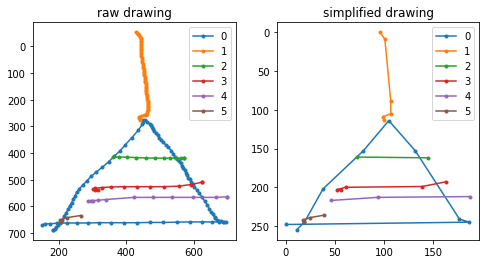

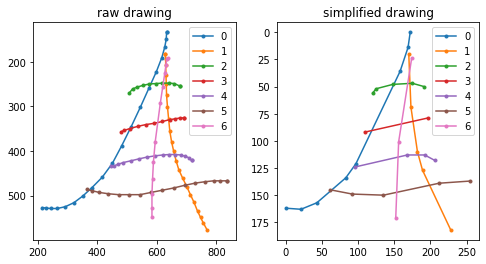

In [15]:
import matplotlib.pyplot as plt

for index in range(5):
    f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    
    # raw_images 그리기
    for x, y, t in raw_images[index]:
        ax1.plot(x, y, marker=".")
    ax1.set_title("raw drawing")
    ax1.invert_yaxis()
    
    # simplified_images 그리기
    for stroke in simple_images[index]:
        # 각 stroke에서 x, y 좌표 추출
        x, y = stroke
        ax2.plot(x, y, marker=".")
    ax2.set_title("simplified drawing")
    ax2.invert_yaxis()
    
    # 레전드 추가
    ax1.legend(range(len(raw_images[index])))
    ax2.legend(range(len(simple_images[index])))
    
    plt.show()

- 같은 그림이지만 point들이 훨씬 촘촘하고 다양한 것을 알 수 있습니다.

- 당장은 이 획을 그리는 '시간' 에 대한 정보를 활용할 방법이 없지만, 이것을 고민해보는 것도 좋은 연구가 될 것같습니다.